# IV值筛选特征：KYC标签取6/14日时点数据

# Part 1. KYC筛选：缺失值补充

In [13]:
import pandas as pd

# 读取Excel文件
file_path = '/Users/suding/Desktop/test.xlsx'
df = pd.read_excel(file_path)

In [14]:
# 统计缺失数量和缺失比例
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# 填充缺失值（使用 "未记录"填充类别变量）
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})
df_filled = df.fillna('未记录')

In [15]:
# 检查填充后的缺失情况
filled_missing_data = df_filled.isnull().sum()
filled_missing_percentage = (df_filled.isnull().sum() / len(df_filled)) * 100

# 创建一个DataFrame来显示填充后的结果
filled_summary = pd.DataFrame({'Missing Count': filled_missing_data, 'Missing Percentage': filled_missing_percentage})

# 显示结果
print("Before filling missing values:")
print(missing_summary)
print("\nAfter filling missing values:")
print(filled_summary)

Before filling missing values:
                         Missing Count  Missing Percentage
customer_id                          0            0.000000
ucub_level_lb                       20            0.054281
age_range_lb                         3            0.008142
manager_sub_branch_name           3069            8.329488
profession_id                        3            0.008142
bal_out_comp_rate                    0            0.000000
if_xsb_bjs_flag                      0            0.000000
if_rzrq_kcb_flag                     0            0.000000
if_comm_kcb_flag                     0            0.000000
if_xsb_flag                          0            0.000000
if_hgt_flag                          0            0.000000
if_rzrq_flag                         0            0.000000
if_qhsp_flag                         0            0.000000
if_cash_flag                         0            0.000000
if_cyb_flag_new                      0            0.000000
if_thip_deps             

# Part 2. KYC筛选：IV值计算

In [16]:
import numpy as np

def calculate_iv(df, feature, target):
    lst = []
    for val in df[feature].unique():
        good_count = len(df[(df[feature] == val) & (df[target] == 0)])
        bad_count = len(df[(df[feature] == val) & (df[target] == 1)])
        all_count = len(df[df[feature] == val])
        
        lst.append({
            'Value': val,
            'All': all_count,
            'Good': good_count,
            'Bad': bad_count
        })
    
    # 计算各变量中各区间的woe值（weight of evidence） & iv值
    iv_df = pd.DataFrame(lst)
    iv_df['Distr_Good'] = iv_df['Good'] / (iv_df['Good'].sum() + 1e-10)
    iv_df['Distr_Bad'] = iv_df['Bad'] / (iv_df['Bad'].sum() + 1e-10)
    iv_df['WOE'] = np.log((iv_df['Distr_Good'] + 1e-10) / (iv_df['Distr_Bad'] + 1e-10))
    iv_df['IV'] = (iv_df['Distr_Good'] - iv_df['Distr_Bad']) * iv_df['WOE']
    iv = iv_df['IV'].sum()
    
    return iv

In [17]:
# 存储各特征iv值
iv_dict = {}
features = df_filled.columns.tolist()
features.remove('customer_id')      # 不对主键customer_id进行计算
features.remove('label')            # 移除目标变量

In [18]:
# 循环计算各特征iv值
for feature in features:
    iv = calculate_iv(df_filled, feature, 'label')
    iv_dict[feature] = iv

iv_df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV'])
iv_df = iv_df.reset_index().rename(columns={'index': 'Feature'})
iv_df = iv_df.sort_values(by='IV', ascending=False)
print(iv_df)

                    Feature            IV
0             ucub_level_lb  9.052694e+00
26  total_asset_total_range  8.294297e+00
9               if_hgt_flag  5.783705e+00
16        if_priv_fund_flag  1.065286e+00
2   manager_sub_branch_name  9.366104e-01
7          if_comm_kcb_flag  8.851855e-01
5           if_xsb_bjs_flag  8.377407e-01
17          if_priv_zg_flag  5.662755e-01
32      mkt_notcrrc_pub_avg  5.455943e-01
22               commi_rate  5.217914e-01
10             if_rzrq_flag  4.767047e-01
13          if_cyb_flag_new  4.239370e-01
23               risk_level  3.942677e-01
27       bal_out_comp_range  3.413051e-01
8               if_xsb_flag  2.780533e-01
6          if_rzrq_kcb_flag  2.167695e-01
28         ctrb_level_range  1.824556e-01
36         if_jhstart_month  1.456065e-01
21        invest_pref_label  1.417441e-01
3             profession_id  1.313991e-01
31       cash_asset_rate_1m  1.155179e-01
25           profit_rate_1y  1.145844e-01
29      stock_asset_rate_1m  7.882

注：IV值筛选标准，在本项目选择具备中等预测能力的变量

IV < 0.02: 无预测力（Not Predictive）
0.02 ≤ IV < 0.1: 弱预测力（Weak Predictive Power）
0.1 ≤ IV < 0.3: 中等预测力（Medium Predictive Power）
0.3 ≤ IV < 0.5: 强预测力（Strong Predictive Power）
IV ≥ 0.5: 非常强预测力（Very Strong Predictive Power

In [19]:
# 选择至少具备弱预测力的kyc标签
selected_features = iv_df[iv_df['IV'] >= 0.02]['Feature'].tolist()
print("Selected features based on IV value:")
print(selected_features)

Selected features based on IV value:
['ucub_level_lb', 'total_asset_total_range', 'if_hgt_flag', 'if_priv_fund_flag', 'manager_sub_branch_name', 'if_comm_kcb_flag', 'if_xsb_bjs_flag', 'if_priv_zg_flag', 'mkt_notcrrc_pub_avg', 'commi_rate', 'if_rzrq_flag', 'if_cyb_flag_new', 'risk_level', 'bal_out_comp_range', 'if_xsb_flag', 'if_rzrq_kcb_flag', 'ctrb_level_range', 'if_jhstart_month', 'invest_pref_label', 'profession_id', 'cash_asset_rate_1m', 'profit_rate_1y', 'stock_asset_rate_1m', 'authenticate_status', 'age_range_lb', 'prod_asset_rate_1m', 'if_jhstart_week', 'if_fy_match_flag', 'if_jh_match_flag']


In [20]:
# 读取变量统计.xlsx
mapping_file_path = '/Users/suding/Desktop/Retail_Customer_Group_Analysis/suding/source_data/变量统计.xlsx'
mapping_df = pd.read_excel(mapping_file_path)

In [21]:
# 将IV值筛选后的变量匹配上对应的中文注释
mapping_dict = dict(zip(mapping_df['字段英文名'], mapping_df['字段注释']))

def map_variables_to_descriptions(selected_features, mapping_dict):
    mapped_descriptions = {feature: mapping_dict.get(feature, 'No Description Available') for feature in selected_features}
    return mapped_descriptions

# 打印匹配结果
mapped_descriptions = map_variables_to_descriptions(selected_features, mapping_dict)
for variable, description in mapped_descriptions.items():
    print(f"Variable: {variable}, Description: {description}")

Variable: ucub_level_lb, Description: 客户星级
Variable: total_asset_total_range, Description: 全资产分档
Variable: if_hgt_flag, Description: 开通沪港通
Variable: if_priv_fund_flag, Description: 开通私募基金合格投资者
Variable: manager_sub_branch_name, Description: 开户来源
Variable: if_comm_kcb_flag, Description: 开通普通科创板
Variable: if_xsb_bjs_flag, Description: 北交所权限开通
Variable: if_priv_zg_flag, Description: 开通私募资管合格投资者
Variable: mkt_notcrrc_pub_avg, Description: 当年非货币公墓基金日均保有金额分档
Variable: commi_rate, Description: 近一年股票佣金率分档
Variable: if_rzrq_flag, Description: 开通融资融券
Variable: if_cyb_flag_new, Description: 开通创业板
Variable: risk_level, Description: 风险等级
Variable: bal_out_comp_range, Description: 司外资产
Variable: if_xsb_flag, Description: 开通新三板
Variable: if_rzrq_kcb_flag, Description: 开通两融科创板
Variable: ctrb_level_range, Description: 价值贡献
Variable: if_jhstart_month, Description: 近一月是否启动app
Variable: invest_pref_label, Description: 投资偏好
Variable: profession_id, Description: 职业信息
Variable: cash_asset_rate_1m, Descriptio

In [58]:
# 保存筛选后的数据集至本地
# 筛选后的特征（至少具备弱预测能力）
selected_features = ['customer_id','ucub_level_lb', 'total_asset_total_range', 'if_hgt_flag', 'if_priv_fund_flag', 
                     'manager_sub_branch_name', 'if_comm_kcb_flag', 'if_xsb_bjs_flag', 'if_priv_zg_flag',
                     'mkt_notcrrc_pub_avg', 'commi_rate', 'if_rzrq_flag', 'if_cyb_flag_new', 'risk_level', 
                     'bal_out_comp_range', 'if_xsb_flag', 'if_rzrq_kcb_flag', 'ctrb_level_range', 'if_jhstart_month', 
                     'invest_pref_label', 'profession_id', 'cash_asset_rate_1m', 'profit_rate_1y', 'stock_asset_rate_1m',
                     'authenticate_status', 'age_range_lb', 'prod_asset_rate_1m', 'if_jhstart_week', 'if_fy_match_flag', 
                     'if_jh_match_flag', 'label']

filtered_df = df_filled[selected_features]

# 保存为本地Excel文件
output_path = '/Users/suding/Desktop/Retail_Customer_Group_Analysis/suding/training_data/filtered_kyc_dataset0619.xlsx'
filtered_df.to_excel(output_path, index=False)

print("筛选后的数据集已保存至本地。")


筛选后的数据集已保存至本地。


# Part 3. 可视化具备强预测力的KYC标签

In [22]:
# 筛选出强预测力的KYC标签
strong_predictive_features = iv_df[iv_df['IV'] >= 0.3]['Feature'].tolist()
print("Strong predictive features based on IV value:")
print(strong_predictive_features)

Strong predictive features based on IV value:
['ucub_level_lb', 'total_asset_total_range', 'if_hgt_flag', 'if_priv_fund_flag', 'manager_sub_branch_name', 'if_comm_kcb_flag', 'if_xsb_bjs_flag', 'if_priv_zg_flag', 'mkt_notcrrc_pub_avg', 'commi_rate', 'if_rzrq_flag', 'if_cyb_flag_new', 'risk_level', 'bal_out_comp_range']


待分析KYC如下：

1. `ucub_level_lb` - 客户星级
2. `total_asset_total_range` - 全资产分档
3. `if_hgt_flag` - 开通沪港通
4. `if_priv_fund_flag` - 开通私募基金合格投资者
5. `manager_sub_branch_name` - 开户来源
6. `if_comm_kcb_flag` - 开通普通科创板
7. `if_xsb_bjs_flag` - 北交所权限开通
8. `if_priv_zg_flag` - 开通私募资管合格投资者
9. `mkt_notcrrc_pub_avg` - 当年非货币公募基金日均保有金额分档
10. `commi_rate` - 近一年股票佣金率分档
11. `if_rzrq_flag` - 开通融资融券
12. `if_cyb_flag_new` - 开通创业板
13. `risk_level` - 风险等级
14. `bal_out_comp_range` - 司外资产

## 客户星级的可视化

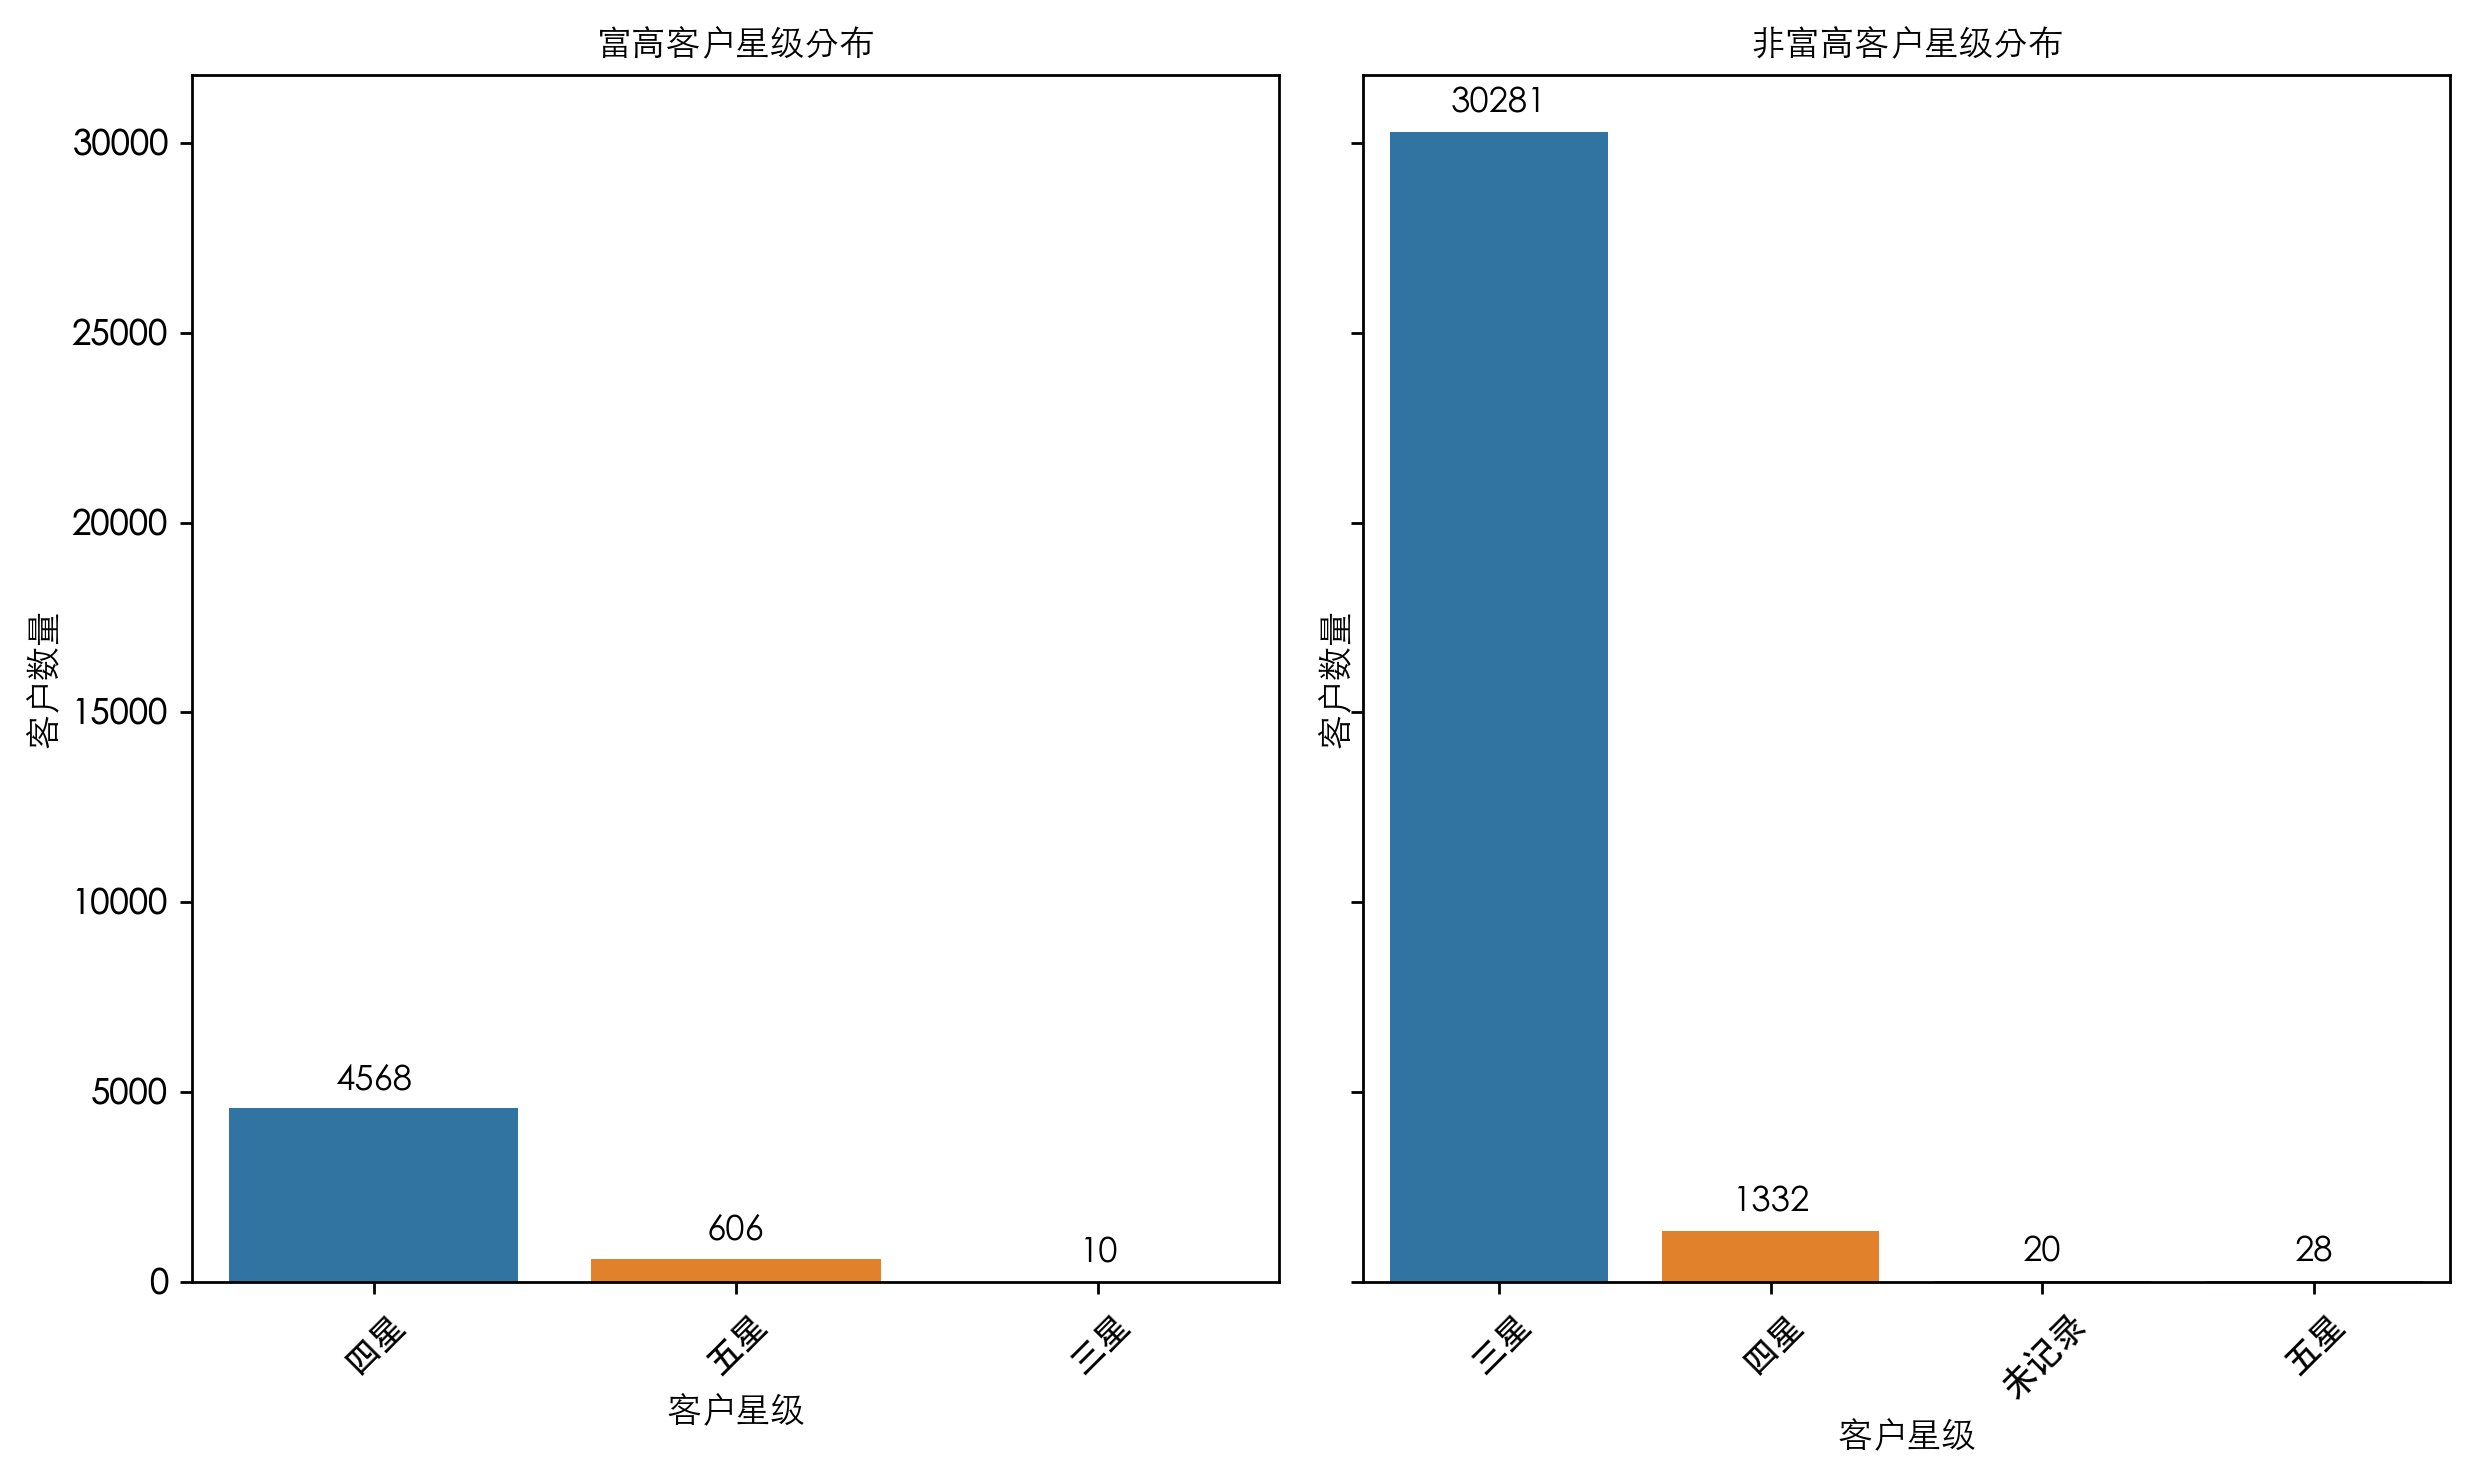

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm

# 添加中文字体
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

positive_examples = df_filled[df_filled['label'] == 1]
negative_examples = df_filled[df_filled['label'] == 0]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), dpi=250, sharey=True)

# 绘制正例的客户星级分布
sns.countplot(x='ucub_level_lb', data=positive_examples, ax=axes[0])
axes[0].set_title('富高客户星级分布', fontproperties=prop)
axes[0].set_xlabel('客户星级', fontproperties=prop)
axes[0].set_ylabel('客户数量', fontproperties=prop)
axes[0].tick_params(axis='x', rotation=45)

# 在正例图表上添加标注
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

# 绘制反例的客户星级分布
sns.countplot(x='ucub_level_lb', data=negative_examples, ax=axes[1])
axes[1].set_title('非富高客户星级分布', fontproperties=prop)
axes[1].set_xlabel('客户星级', fontproperties=prop)
axes[1].set_ylabel('客户数量', fontproperties=prop)
axes[1].tick_params(axis='x', rotation=45)

# 在反例图表上添加标注
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

plt.tight_layout()
plt.show()

## 全资产分档的可视化

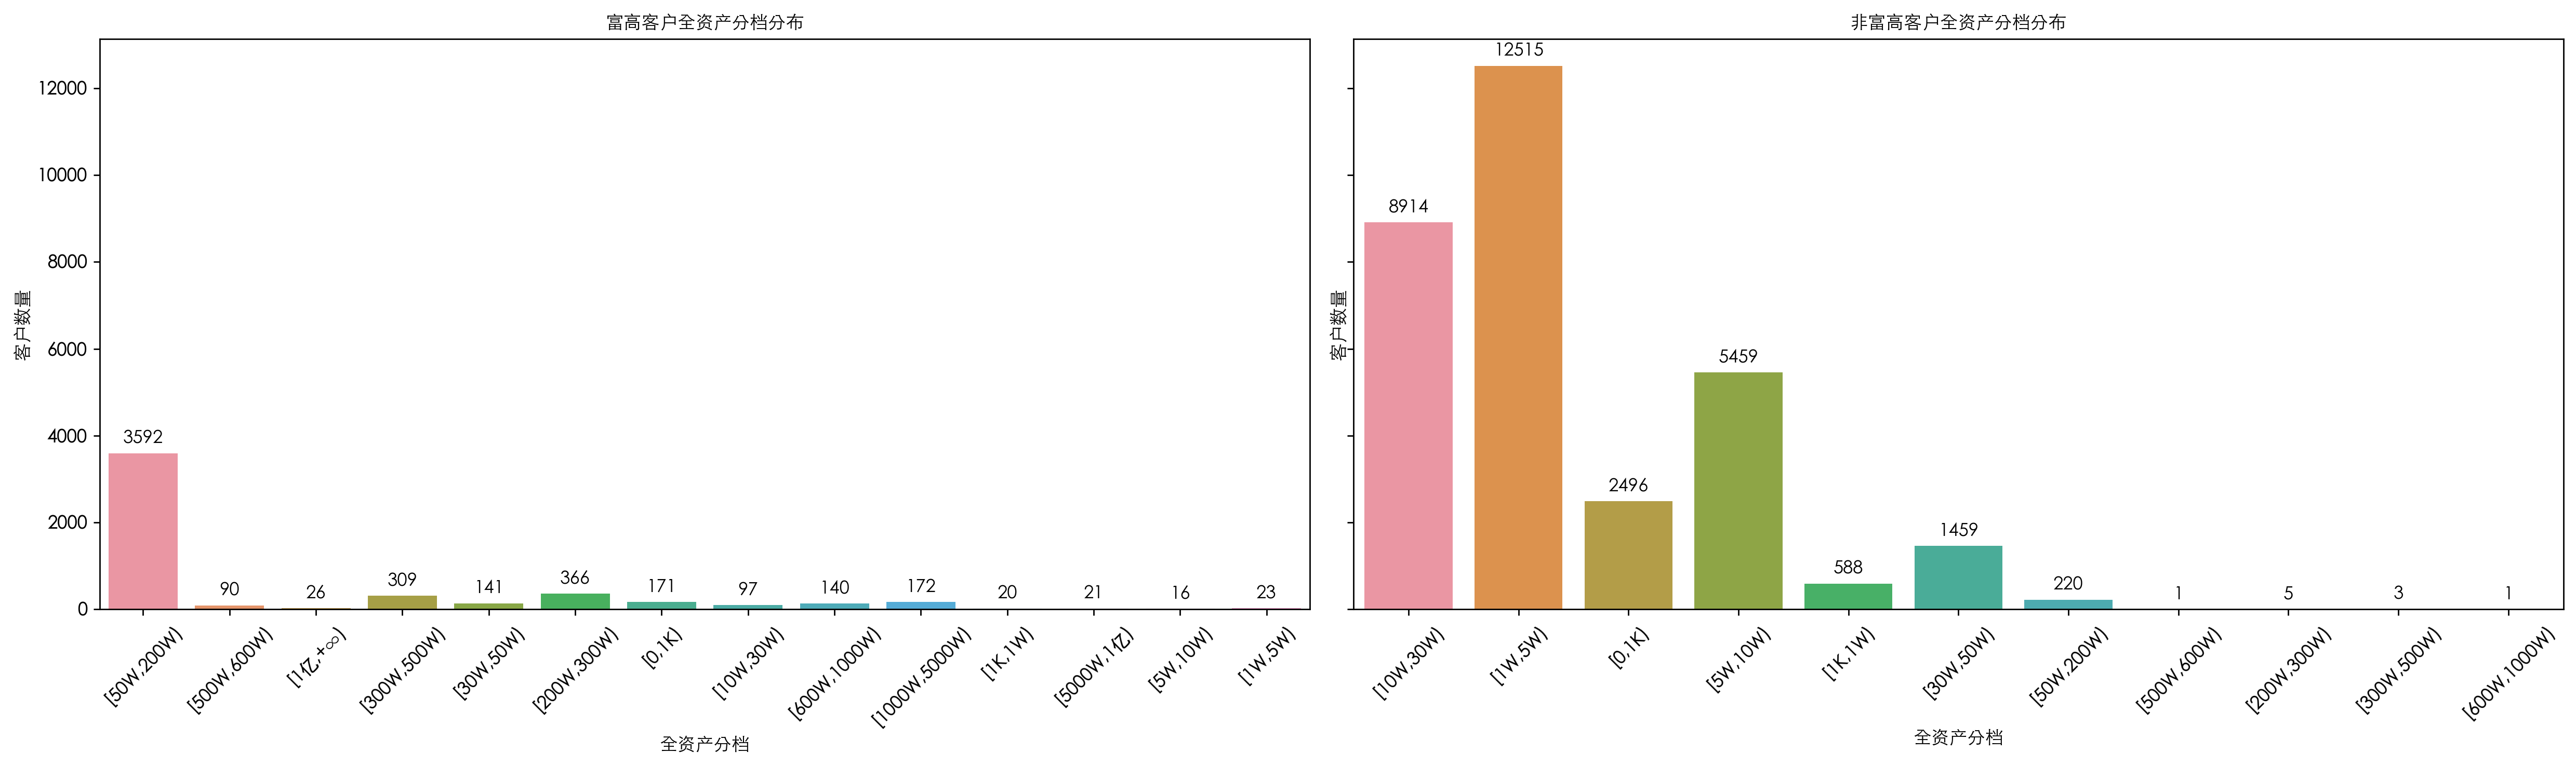

In [42]:
# 拉长图片大小
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), dpi=250, sharey=True)

# 绘制正例的客户星级分布
sns.countplot(x='total_asset_total_range', data=positive_examples, ax=axes[0])
axes[0].set_title('富高客户全资产分档分布', fontproperties=prop)
axes[0].set_xlabel('全资产分档', fontproperties=prop)
axes[0].set_ylabel('客户数量', fontproperties=prop)
axes[0].tick_params(axis='x', rotation=45)

# 在正例图表上添加标注
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

# 绘制反例的客户星级分布
sns.countplot(x='total_asset_total_range', data=negative_examples, ax=axes[1])
axes[1].set_title('非富高客户全资产分档分布', fontproperties=prop)
axes[1].set_xlabel('全资产分档', fontproperties=prop)
axes[1].set_ylabel('客户数量', fontproperties=prop)
axes[1].tick_params(axis='x', rotation=45)

# 在反例图表上添加标注
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

plt.tight_layout()
plt.show()

## 权限开通的可视化

In [56]:
# 权限开通相关字段
fields = {
    'if_hgt_flag': '开通沪港通',
    'if_priv_fund_flag': '开通私募基金合格投资者',
    'if_comm_kcb_flag': '开通普通科创板',
    'if_xsb_bjs_flag': '北交所权限开通',
    'if_priv_zg_flag': '开通私募资管合格投资者',
    'if_rzrq_flag': '开通融资融券',
    'if_cyb_flag_new': '开通创业板'
}

# 设置画布和子图，调整figsize和dpi
fig, axes = plt.subplots(nrows=len(fields), ncols=2, figsize=(20, len(fields) * 8), dpi=300, sharey=False)

# 绘制每个权限字段的正反例分布图
for i, (field, desc) in enumerate(fields.items()):
    # 正例
    sns.countplot(x=field, data=positive_examples, ax=axes[i, 0], linewidth=0.5, edgecolor='black')
    axes[i, 0].set_title(f'正例 - {desc}', fontproperties=prop)
    axes[i, 0].set_xlabel(desc, fontproperties=prop)
    axes[i, 0].set_ylabel('客户数量', fontproperties=prop)
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # 添加标注
    for p in axes[i, 0].patches:
        height = p.get_height()
        axes[i, 0].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                            xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)
    
    # 反例
    sns.countplot(x=field, data=negative_examples, ax=axes[i, 1], linewidth=0.5, edgecolor='black')
    axes[i, 1].set_title(f'反例 - {desc}', fontproperties=prop)
    axes[i, 1].set_xlabel(desc, fontproperties=prop)
    axes[i, 1].set_ylabel('客户数量', fontproperties=prop)
    axes[i, 1].tick_params(axis='x', rotation=45)
    
    # 添加标注
    for p in axes[i, 1].patches:
        height = p.get_height()
        axes[i, 1].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                            xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

# 调整布局
plt.tight_layout()
plt.show()

## 当年非货币公募基金日均保有金额分档的可视化

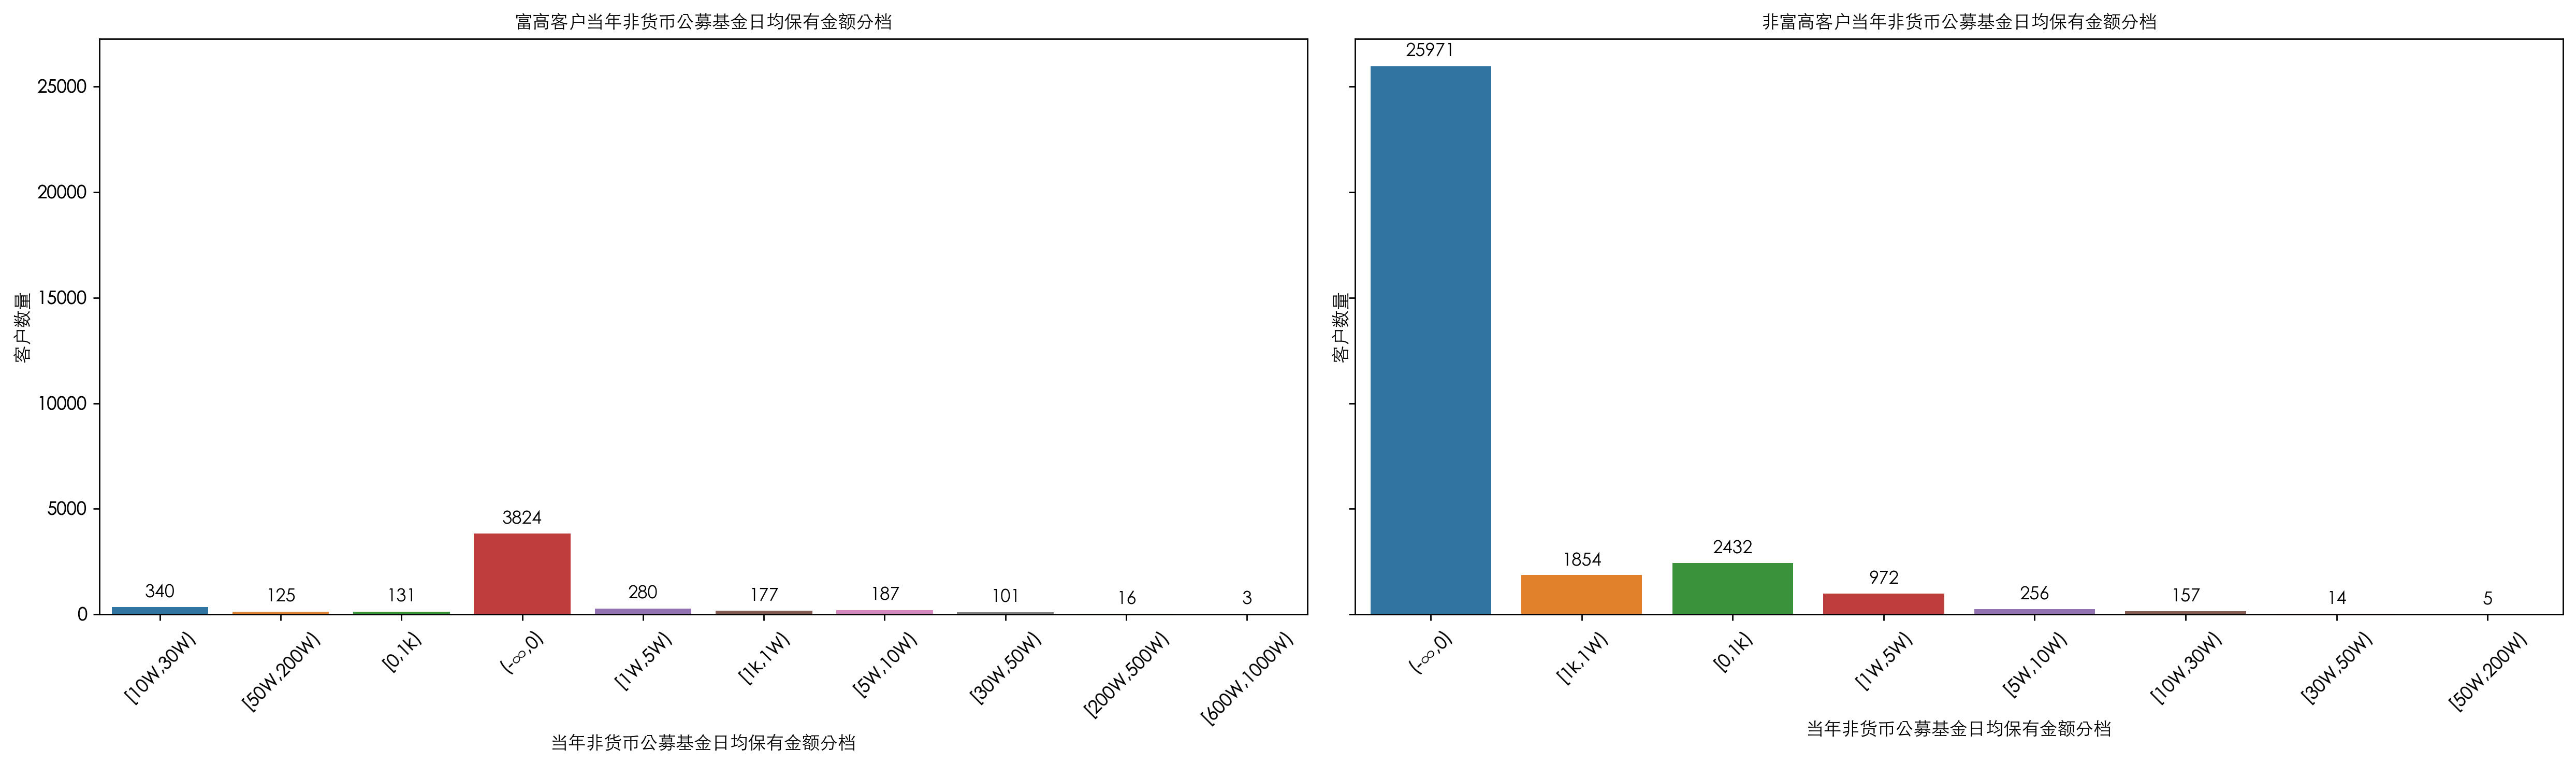

In [44]:
# 当年非货币公募基金日均保有金额分档
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), dpi=250, sharey=True)

sns.countplot(x='mkt_notcrrc_pub_avg', data=positive_examples, ax=axes[0])
axes[0].set_title('富高客户当年非货币公募基金日均保有金额分档', fontproperties=prop)
axes[0].set_xlabel('当年非货币公募基金日均保有金额分档', fontproperties=prop)
axes[0].set_ylabel('客户数量', fontproperties=prop)
axes[0].tick_params(axis='x', rotation=45)

for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

sns.countplot(x='mkt_notcrrc_pub_avg', data=negative_examples, ax=axes[1])
axes[1].set_title('非富高客户当年非货币公募基金日均保有金额分档', fontproperties=prop)
axes[1].set_xlabel('当年非货币公募基金日均保有金额分档', fontproperties=prop)
axes[1].set_ylabel('客户数量', fontproperties=prop)
axes[1].tick_params(axis='x', rotation=45)

for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

plt.tight_layout()
plt.show()

## 近一年股票佣金率分档可视化

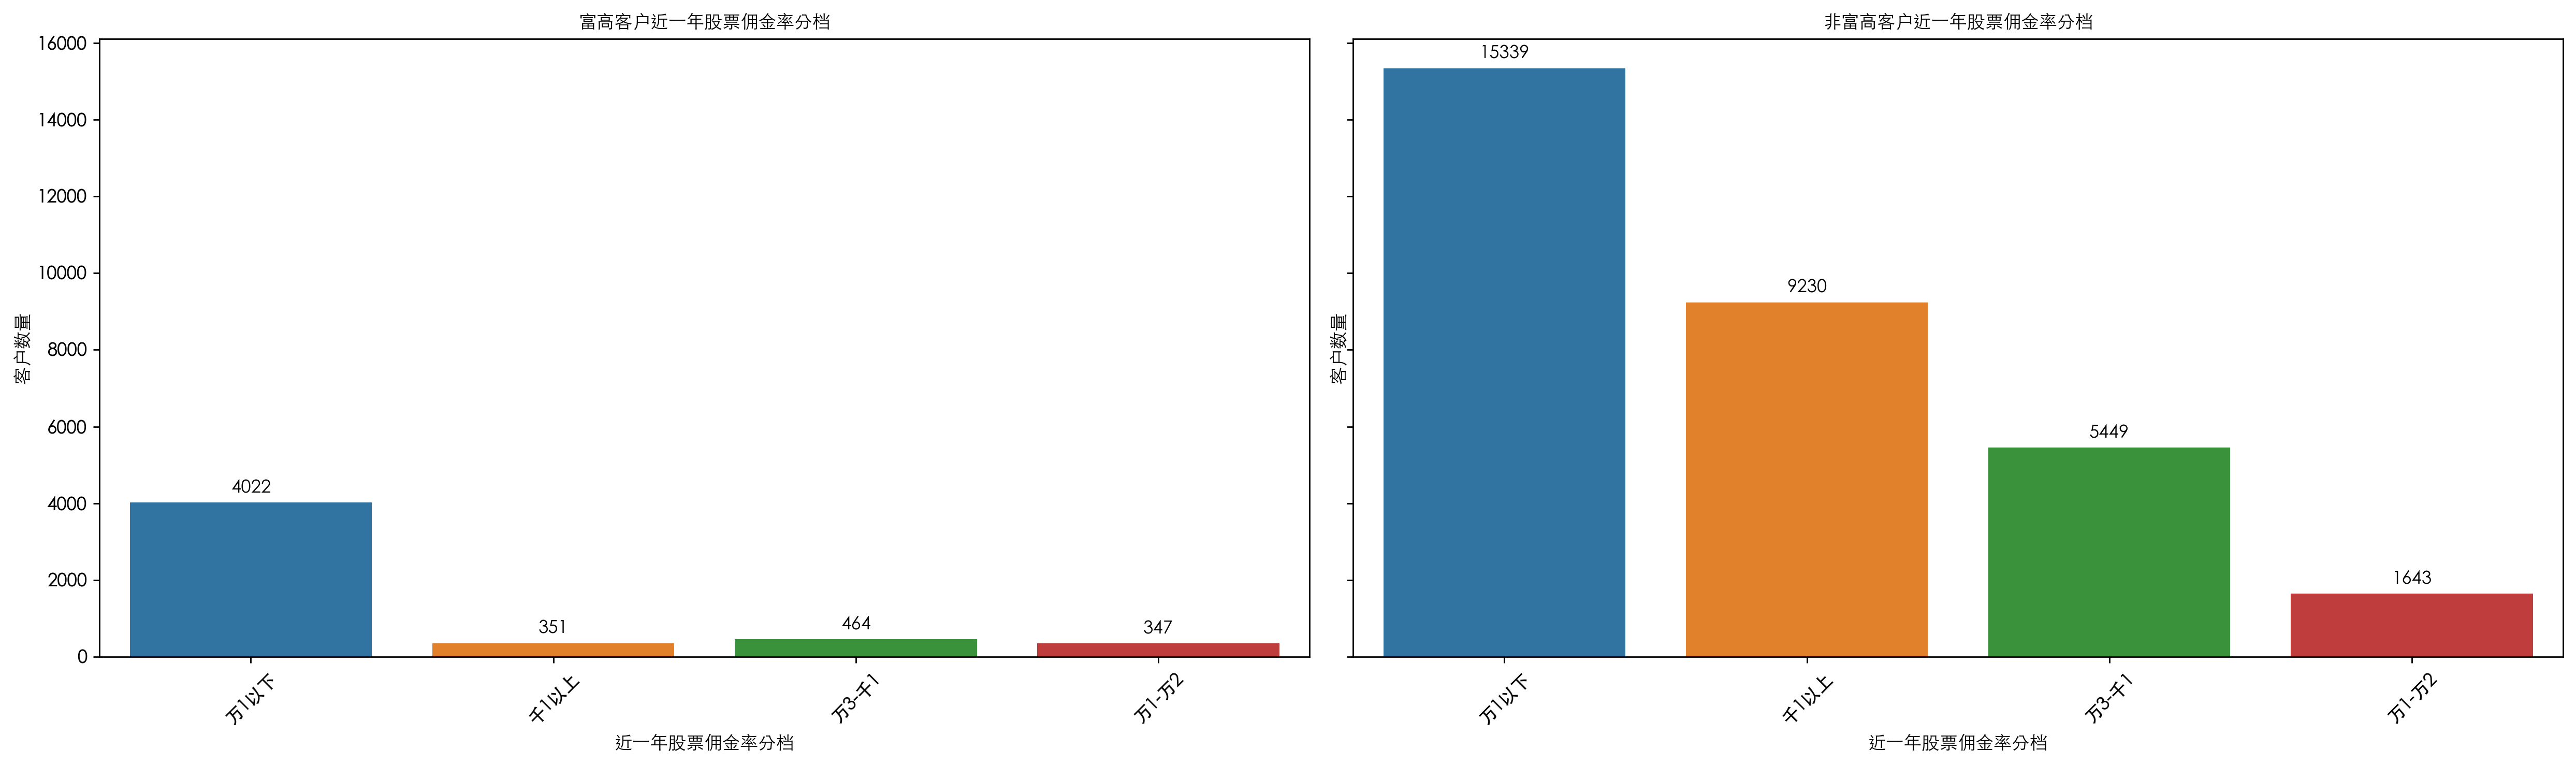

In [45]:
# 近一年股票佣金率分档
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), dpi=250, sharey=True)

sns.countplot(x='commi_rate', data=positive_examples, ax=axes[0])
axes[0].set_title('富高客户近一年股票佣金率分档', fontproperties=prop)
axes[0].set_xlabel('近一年股票佣金率分档', fontproperties=prop)
axes[0].set_ylabel('客户数量', fontproperties=prop)
axes[0].tick_params(axis='x', rotation=45)

for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

sns.countplot(x='commi_rate', data=negative_examples, ax=axes[1])
axes[1].set_title('非富高客户近一年股票佣金率分档', fontproperties=prop)
axes[1].set_xlabel('近一年股票佣金率分档', fontproperties=prop)
axes[1].set_ylabel('客户数量', fontproperties=prop)
axes[1].tick_params(axis='x', rotation=45)

for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

plt.tight_layout()
plt.show()

## 风险等级可视化

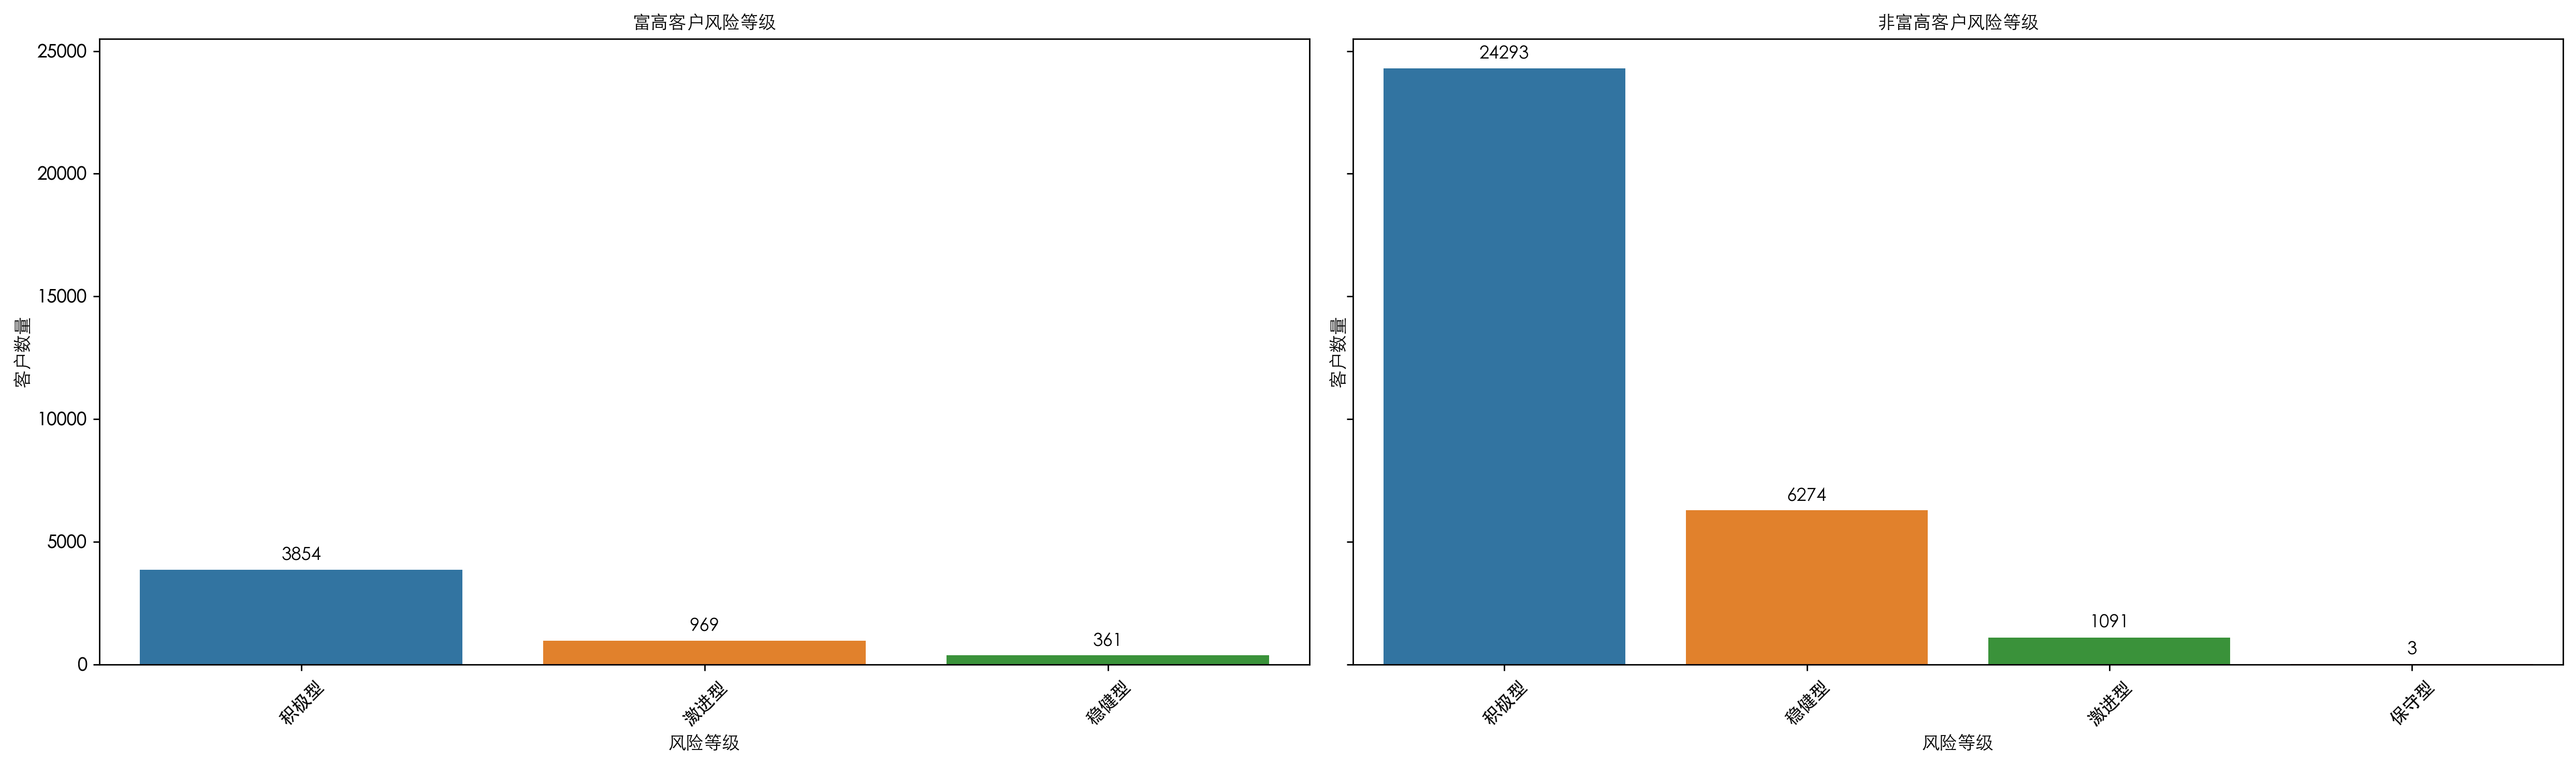

In [46]:
# 风险等级
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), dpi=250, sharey=True)

sns.countplot(x='risk_level', data=positive_examples, ax=axes[0])
axes[0].set_title('富高客户风险等级', fontproperties=prop)
axes[0].set_xlabel('风险等级', fontproperties=prop)
axes[0].set_ylabel('客户数量', fontproperties=prop)
axes[0].tick_params(axis='x', rotation=45)

for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

sns.countplot(x='risk_level', data=negative_examples, ax=axes[1])
axes[1].set_title('非富高客户风险等级', fontproperties=prop)
axes[1].set_xlabel('风险等级', fontproperties=prop)
axes[1].set_ylabel('客户数量', fontproperties=prop)
axes[1].tick_params(axis='x', rotation=45)

for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

plt.tight_layout()
plt.show()

## 司外资产可视化

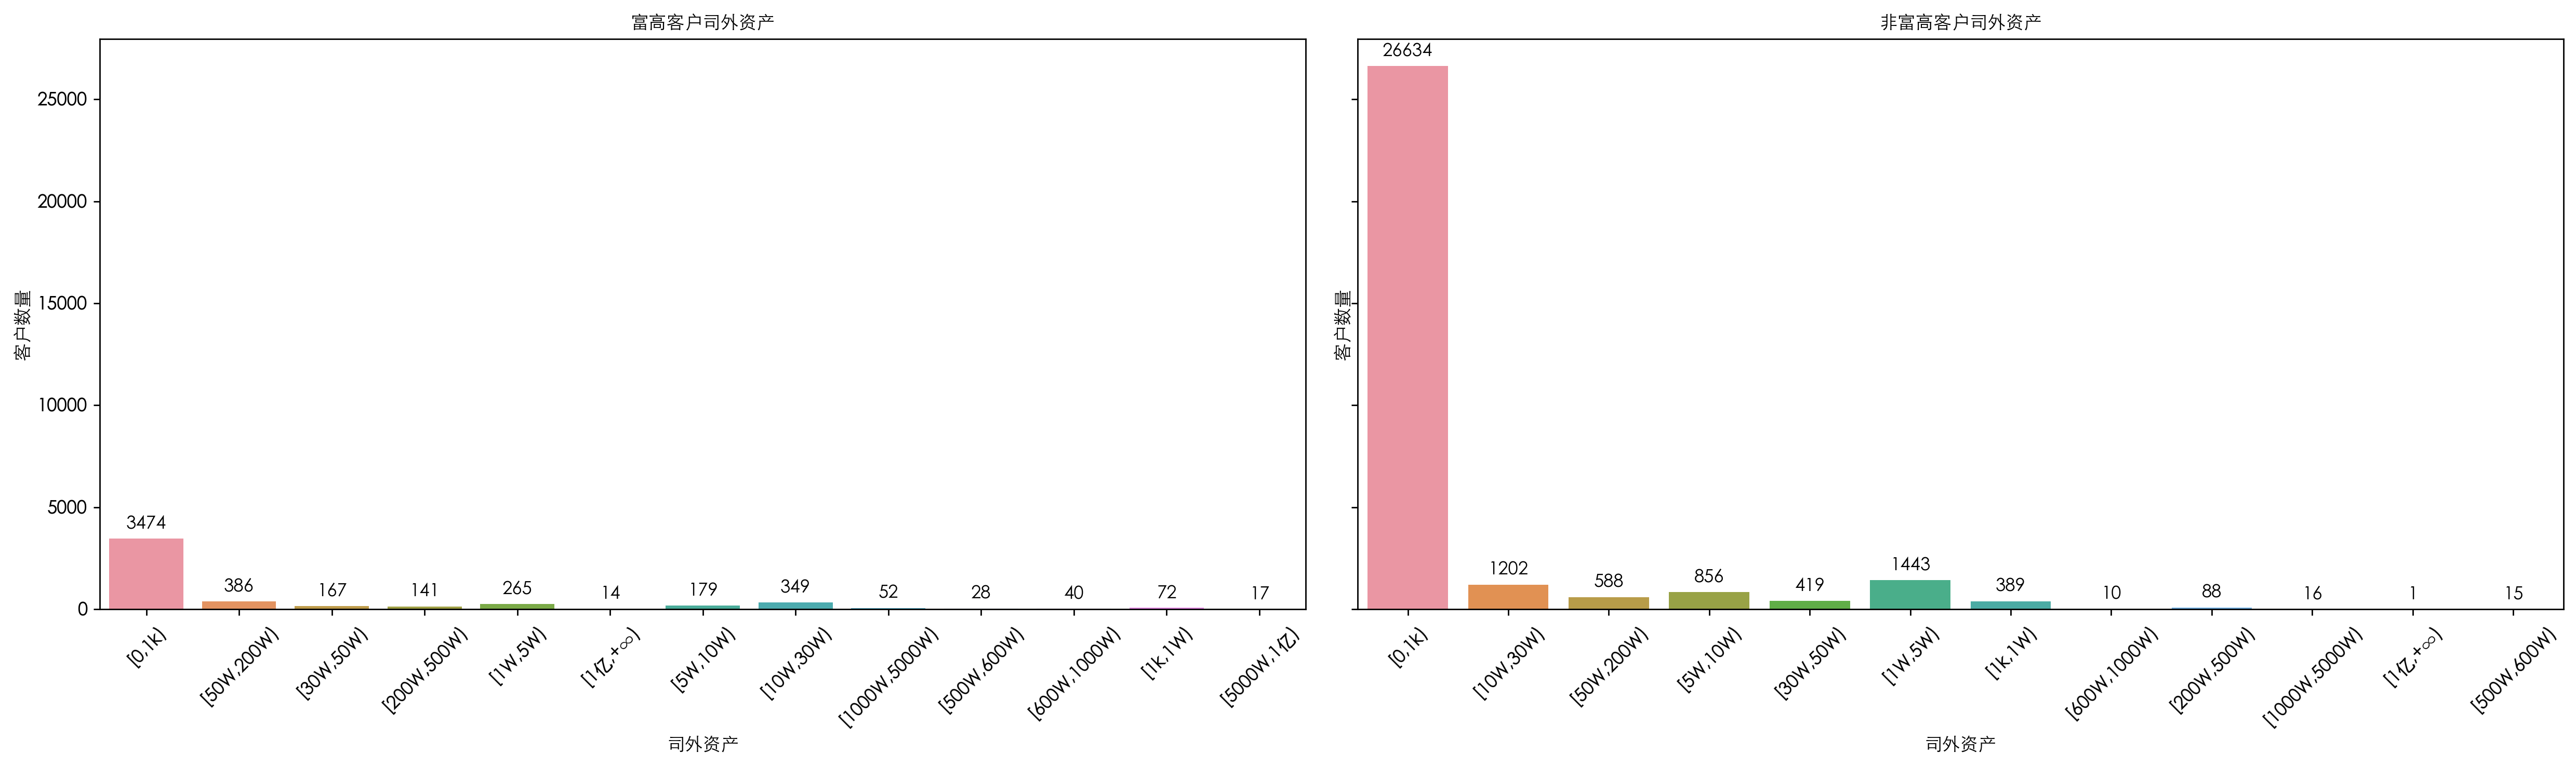

In [48]:
# 司外资产
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), dpi=250, sharey=True)

sns.countplot(x='bal_out_comp_range', data=positive_examples, ax=axes[0])
axes[0].set_title('富高客户司外资产', fontproperties=prop)
axes[0].set_xlabel('司外资产', fontproperties=prop)
axes[0].set_ylabel('客户数量', fontproperties=prop)
axes[0].tick_params(axis='x', rotation=45)

for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

sns.countplot(x='bal_out_comp_range', data=negative_examples, ax=axes[1])
axes[1].set_title('非富高客户司外资产', fontproperties=prop)
axes[1].set_xlabel('司外资产', fontproperties=prop)
axes[1].set_ylabel('客户数量', fontproperties=prop)
axes[1].tick_params(axis='x', rotation=45)

for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height), 
                     xytext=(0, 5), textcoords='offset points', ha='center', fontproperties=prop)

plt.tight_layout()
plt.show()

## 富高客户最多的前十营业部

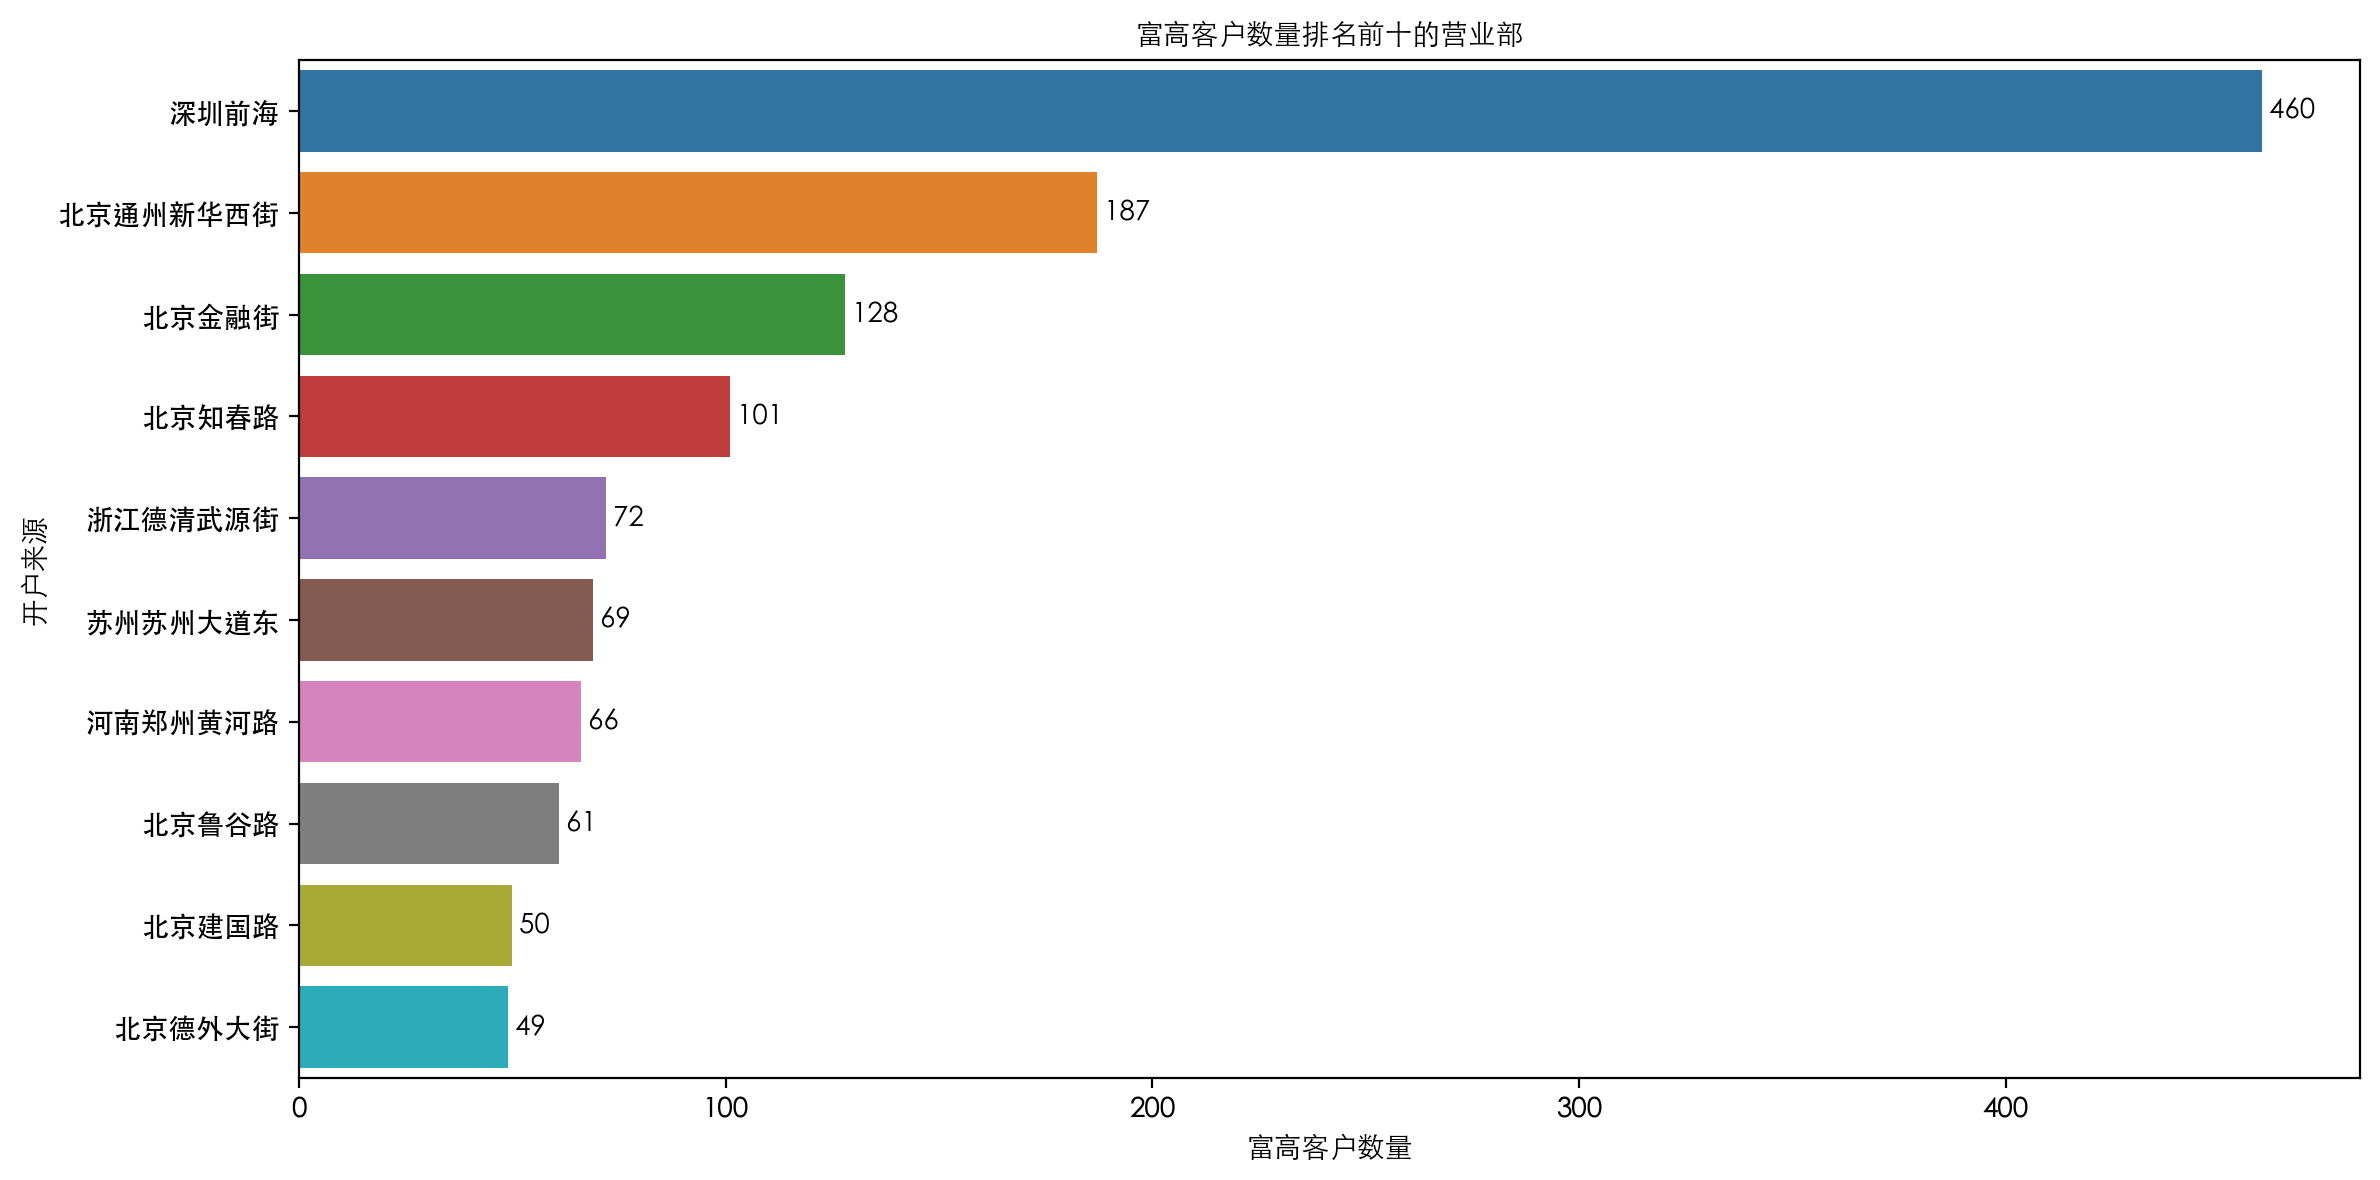

In [50]:
# 去除未记录的营业部
filtered_positive_examples = positive_examples[positive_examples['manager_sub_branch_name'] != '未记录']

# 计算每个营业部的富高客户数量
branch_counts = filtered_positive_examples['manager_sub_branch_name'].value_counts().head(10)

# 可视化排名前十的营业部及其富高客户数量
plt.figure(figsize=(12, 6), dpi=200)
sns.barplot(x=branch_counts.values, y=branch_counts.index)
plt.title('富高客户数量排名前十的营业部', fontproperties=prop)
plt.xlabel('富高客户数量', fontproperties=prop)
plt.ylabel('开户来源', fontproperties=prop)

for i, v in enumerate(branch_counts.values):
    plt.text(v, i, f' {v}', va='center', fontproperties=prop)

plt.tight_layout()
plt.show()